In [28]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries

from photutils.centroids import centroid_quadratic

from plotimg import plot_images

from cluplus.proxy  import invoke


In [29]:
from plotimg import plot_images

async def focus_calc(focus, radius_data, images, source_detection):

    for idx, img in enumerate(images):
        images[idx].data = median_filter(images[idx].data, size=2)
        
        # photutils.background
        bkg_estimator = MedianBackground()
        bkg = Background2D(img.data.astype(float), (50, 50), filter_size=(3, 3),
                           bkg_estimator=bkg_estimator)
        images[idx].data = images[idx].data.astype(float) - bkg.background
        bkg_median = np.median(bkg.background)
        bkg_std = np.std(bkg.background)

        # sep.background
#        images[idx].bkg = sep.Background(images[idx].data.astype(float))
#        images[idx].data = images[idx].data.astype(float) - images[idx].bkg
#        bkg_median = np.median(images[idx].bkg)
#        bkg_std = np.std(bkg_median)
        
    for idx, img in enumerate(images):
        images[idx] = await source_detection(img)
#        images[idx].catalog.sort("fwhm")
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] > bkg_median + (1 * bkg_std) ]
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] < 65000]
#        images[idx].catalog = images[idx].catalog[images[idx].catalog["ellipticity"] < 0.3]
        images[idx].catalog.sort("flux")
        images[idx].catalog.reverse()

        sources = images[idx].catalog
        if (len(sources) > 2):
            radius = np.median(sources[column][:num_stars])
            radius_err = np.std(sources[column][:num_stars])
            radius_data[idx].append({"focus": focus, "r": radius, "rerr": radius_err})

    return bkg_median, bkg_std


In [30]:
from lvmagp.focus.curvefit import fit_hyperbola

def focus_plot(images, data):
    #print(data)

    fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(8, 5/len(data)))

    for idx, dd in enumerate(data):
        focus = [d["focus"] for d in dd]
        r = [d["r"] for d in dd]
        rerr = [d["rerr"] for d in dd]

        ax_idx = ax[idx] if len(data) > 1 else ax
        ax_idx.set_title(images[idx].header["CAMNAME"])
        ax_idx.errorbar(focus, r, yerr=rerr)

        fit_focus, fit_err = fit_hyperbola(focus, r, rerr)
        print(f"focus: {fit_focus}, {fit_err}")


 focus: 37.0 exptime: 5.0 file: /data/lvm/sci/agcam/east/20221028/lvm.sci.agcam.east_00000392.fits
 bkg_median: 128.03046906258072 bkg_std: 24.728654653604384
      peak      
----------------
 16989.521484375
  9338.849609375
6396.94873046875
4129.65087890625


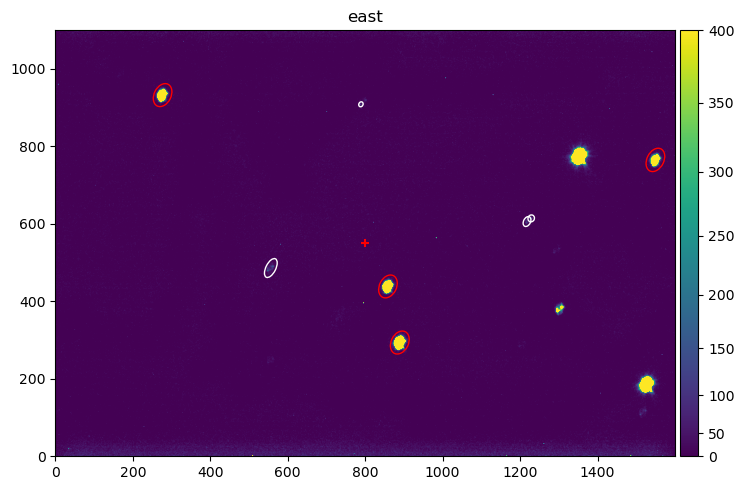

 focus: 38.0 exptime: 5.0 file: /data/lvm/sci/agcam/east/20221028/lvm.sci.agcam.east_00000393.fits
 bkg_median: 128.0053055115469 bkg_std: 24.506958379103704
      peak      
----------------
  23596.15234375
12144.8623046875
 8300.8330078125
   5631.32421875


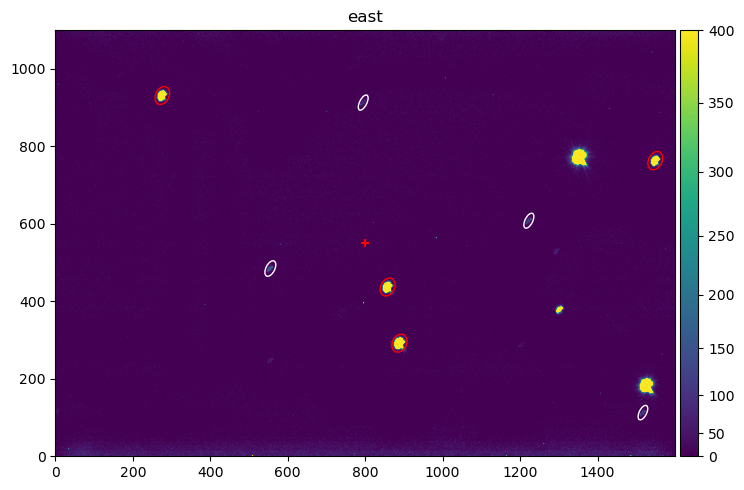

 focus: 39.0 exptime: 5.0 file: /data/lvm/sci/agcam/east/20221028/lvm.sci.agcam.east_00000394.fits
 bkg_median: 128.01723854704548 bkg_std: 24.63476430229498
      peak      
----------------
 25453.470703125
14576.7158203125
 9835.9091796875
5969.53564453125


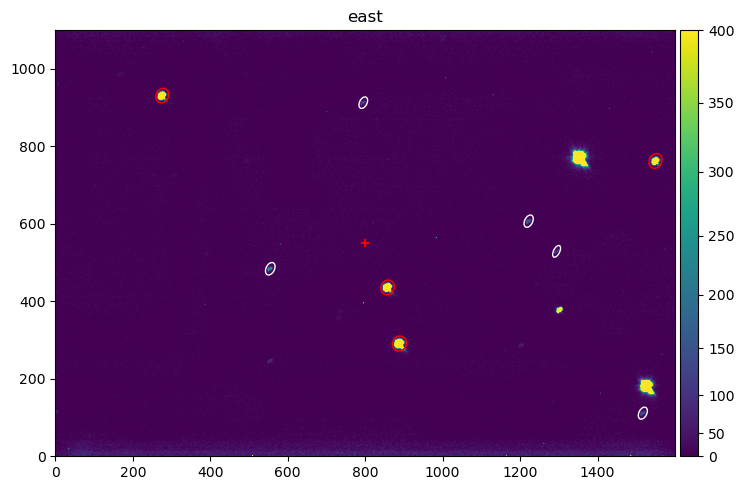

 focus: 40.0 exptime: 5.0 file: /data/lvm/sci/agcam/east/20221028/lvm.sci.agcam.east_00000395.fits
 bkg_median: 128.02648445648862 bkg_std: 24.74606229373638
      peak      
----------------
 20124.650390625
 11215.228515625
    8254.3984375
5808.52587890625


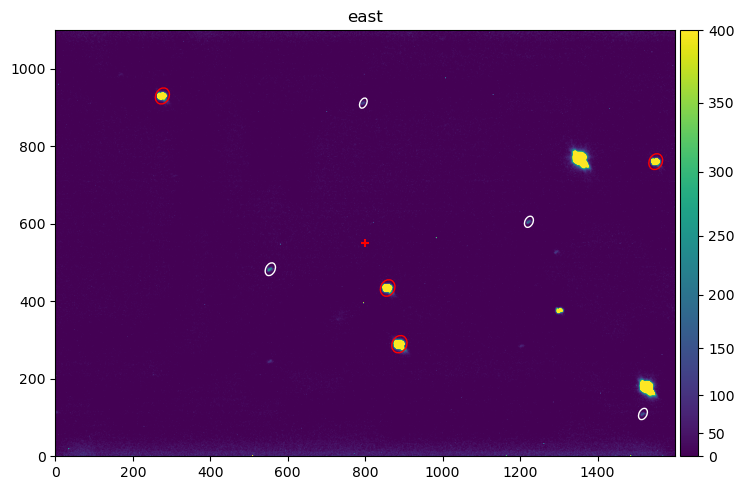

 focus: 41.0 exptime: 5.0 file: /data/lvm/sci/agcam/east/20221028/lvm.sci.agcam.east_00000396.fits
 bkg_median: 128.00300544287586 bkg_std: 24.66934761170418
      peak      
----------------
  26045.22265625
  14623.07421875
10027.9599609375
6768.42138671875


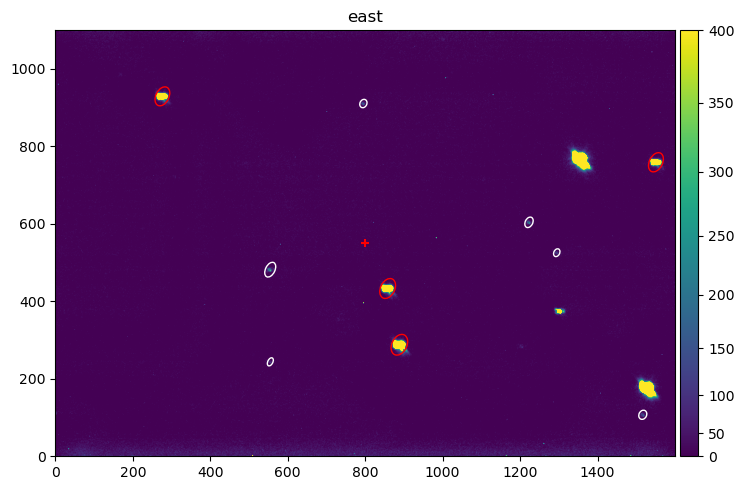

focus: 39.30346955191285, 0.003866575129748113


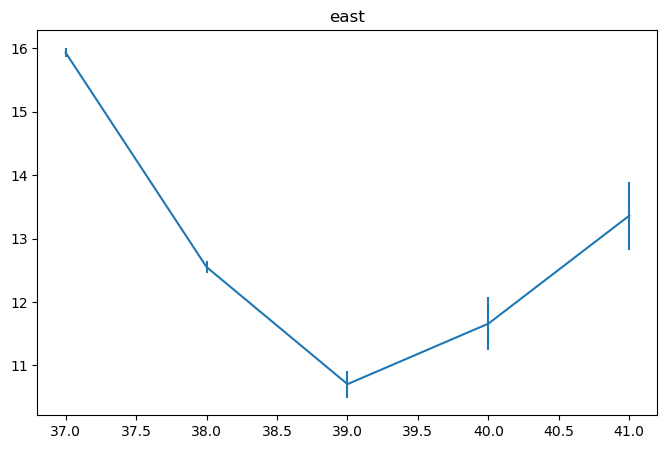

In [27]:
%matplotlib inline
#%matplotlib widget

off=400
num=15

off=404
num=5

off=391
num=7

off=392
num=5

#off=319 # to short 36 - 38, 0.5
#num=5

#off=329 #bad
#num=5

off=392
num=5

#off=365
#num=1

#off=400
#num=14

#off=430
#num=14

#off=415
#num=14

#off=419
#num=5


threshold = 3.2
minarea = 24.0
deblend_nthresh = 1.2
deblend_cont = 0.01

num_stars = 4

source_detection = SepSourceDetection(threshold=threshold, minarea=minarea, deblend_nthresh=deblend_nthresh, deblend_cont=deblend_cont)
#source_detection = SepSourceDetection()
#source_detection = DaophotSourceDetection(fwhm=4, threshold=30)

column = "fwhm"

radius_data = [[]]

fbase = lambda idx: f"/data/lvm/sci/agcam/east/20221028/lvm.sci.agcam.east_{idx:08}.fits"

for i in range(num):
    images = [Image.from_file(fbase(i+off))]
    focus = images[0].header["FOCUSUM"]
#    print(images[0].header)
    print(f" focus: {focus} exptime: {images[0].header['EXPTIME']} file: {fbase(i+off)}")

    bkg_median, bkg_std = await focus_calc(focus, radius_data, images, source_detection)
    print(f" bkg_median: {bkg_median} bkg_std: {bkg_std}")

#    imag = await DaophotSourceDetection()(images[0])
    print(images[0].catalog[:num_stars]["peak"])
    plot_images(images, cat_max=num_stars, cat_rest=True, vmax=400)

focus_plot(images, radius_data)


 focus: 31.0 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000157.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000158.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000041.fits']


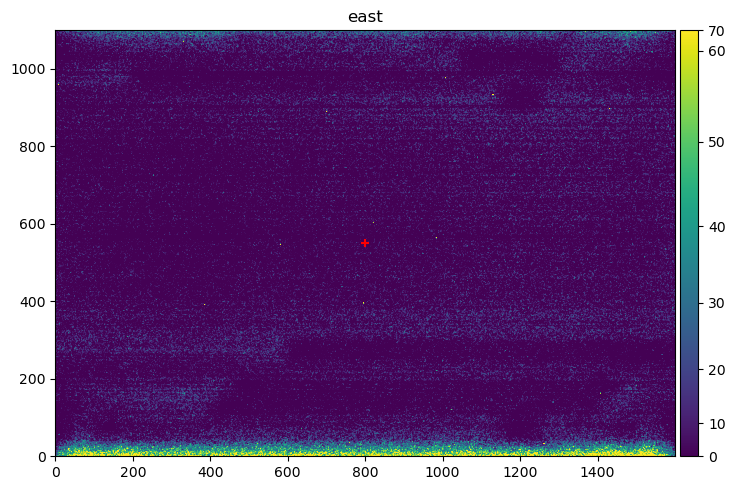

 focus: 32.111111111111114 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000158.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000159.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000042.fits']


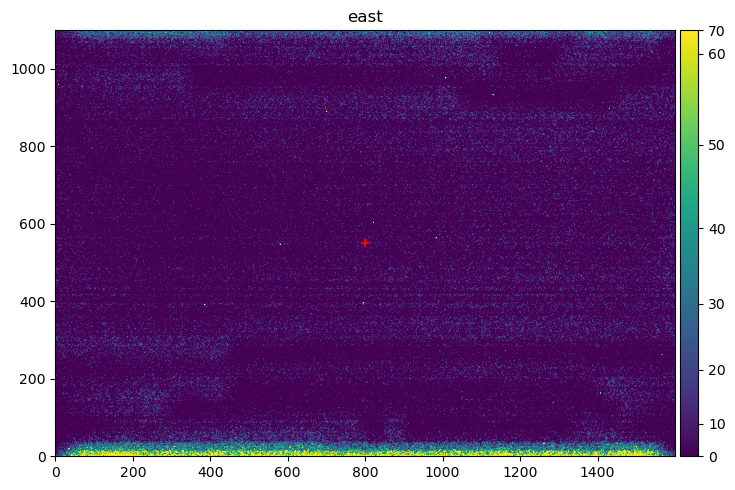

 focus: 33.22222222222222 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000159.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000160.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000043.fits']


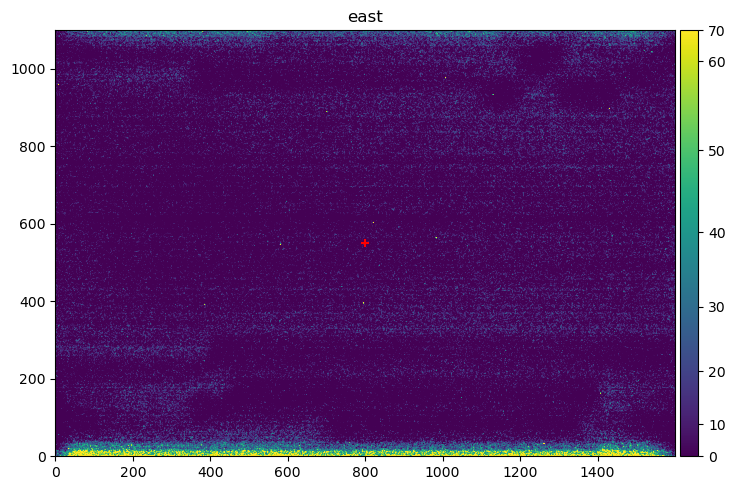

 focus: 34.333333333333336 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000160.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000161.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000044.fits']


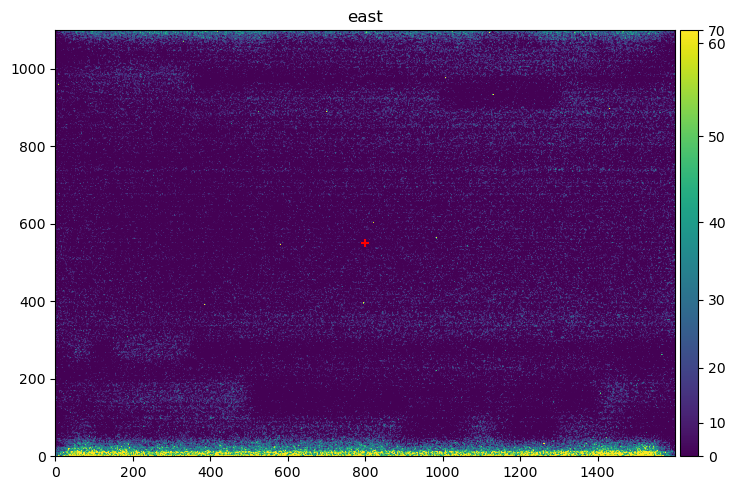

 focus: 35.44444444444444 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000161.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000162.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000045.fits']


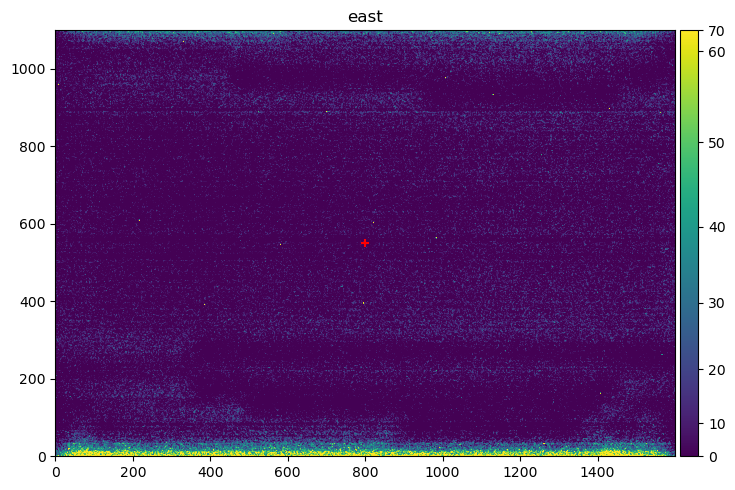

 focus: 36.55555555555556 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000162.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000163.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000046.fits']


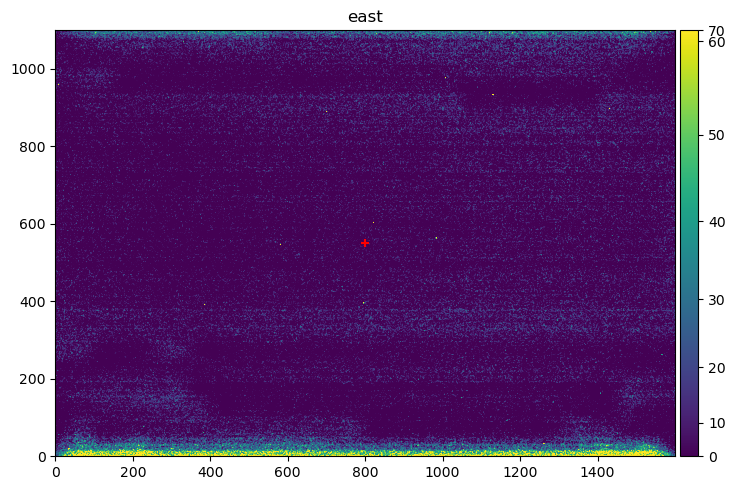

 focus: 37.666666666666664 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000163.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000164.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000047.fits']


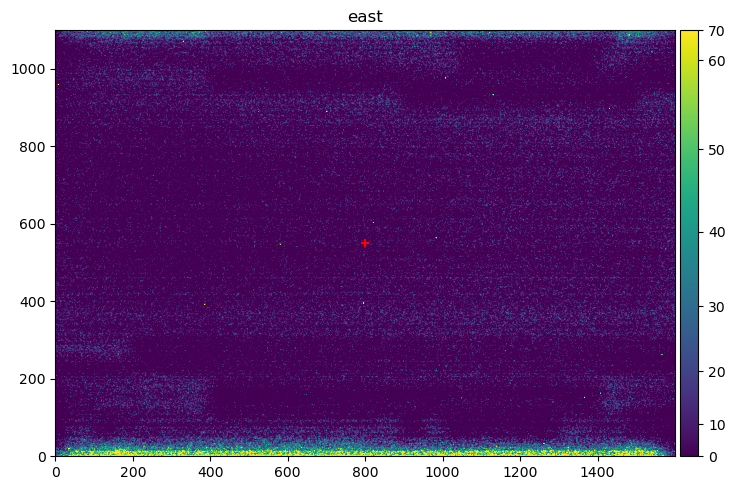

 focus: 38.77777777777778 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000164.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000165.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000048.fits']


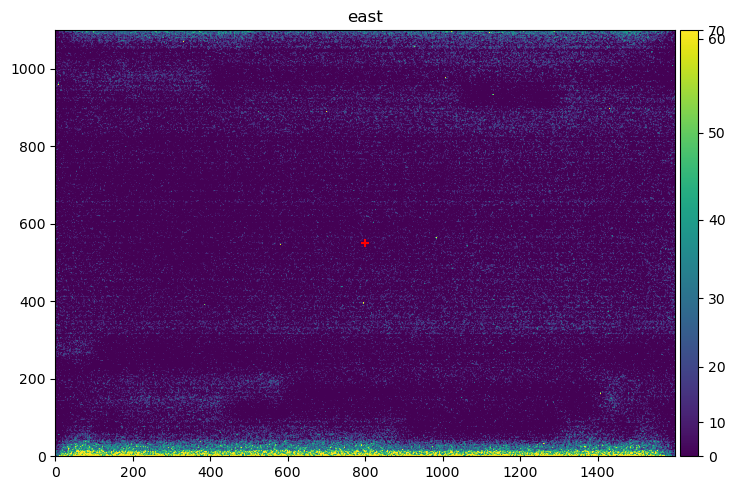

 focus: 39.888888888888886 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000165.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000166.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000049.fits']


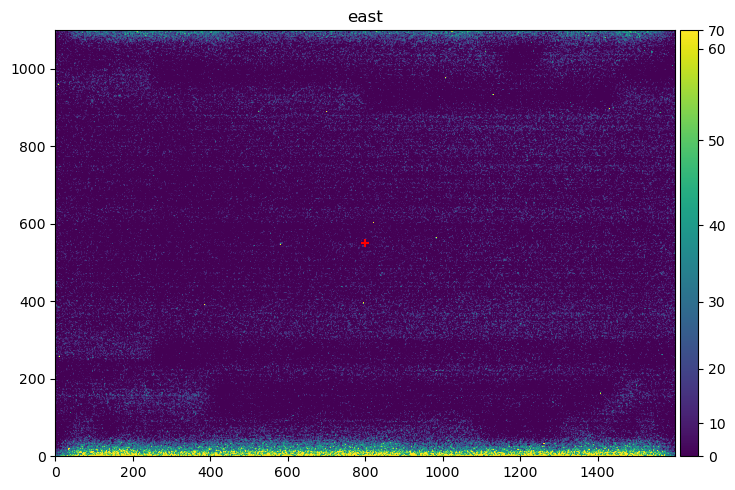

 focus: 41.0 file: ['/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000166.fits', '/data/lvm/sci/agcam/west/20221110/lvm.sci.agcam.west_00000167.fits', '/data/lvm/spec/agcam/center/20221110/lvm.spec.agcam.center_00000050.fits']


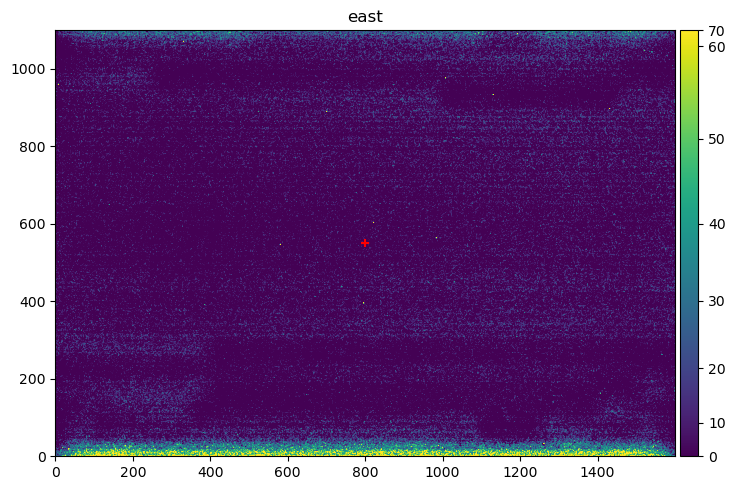

ValueError: attempt to get argmin of an empty sequence

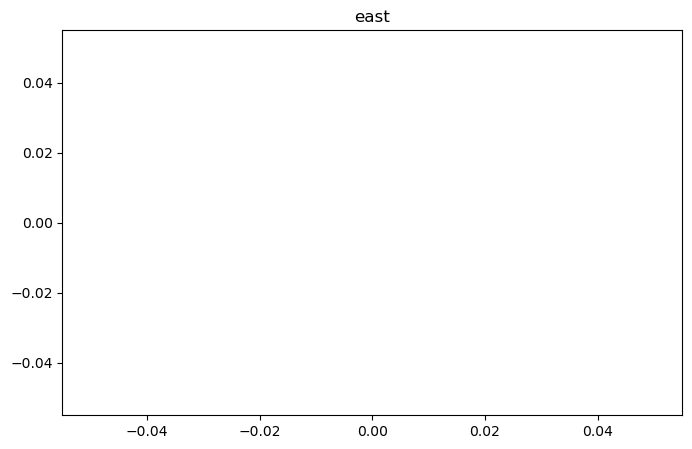

In [63]:
%matplotlib inline
#%matplotlib widget

from lvmtipo.actors import lvm

focus_guess=36
threshold = 12.0
minarea = 24.0
deblend_nthresh = 1.4

source_detection = SepSourceDetection(threshold= threshold, minarea=minarea, deblend_nthresh=deblend_nthresh)

num_stars = 2

await lvm.sci.pwi.start()
await lvm.sci.pwi.status()
await lvm.sci.foc.start()
await lvm.sci.foc.status()

await lvm.sci.agc.start()
await lvm.spec.agc.start()

radius_data = None
expotime = 5.0

for focus in np.linspace(focus_guess-5, focus_guess+5, num=10):
    await lvm.sci.foc.moveAbsolute(focus, "DT")    
    filenames = (
        await invoke(
            lvm.sci.agc.expose(expotime),
            lvm.spec.agc.expose(expotime+0.5)
        )
    ).flatten().unpack("*.filename")
    print(f" focus: {focus} file: {filenames}")
    images = [[Image.from_file(f) for f in filenames][0]]

    if not radius_data: radius_data = [list()]*len(images)
    await focus_calc(focus, radius_data, images, source_detection)
    plot_images(images, cat_max=num_stars, cat_rest=True)


focus_plot(images, radius_data)